In [1]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive

drive.mount('/content/drive/')
!pip install ipywidgets

Mounted at /content/drive/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.5 MB/s eta 0:00:00


## Implementation of different kinds of importance sampling & Visualization tool

In [ ]:
# Random distribution to try
# Highly oscillatory asymmetrical
from scipy.integrate import quad

# Parameters for the distribution
lambda_ = 0.5  # Decay rate
omega = 10     # Frequency of oscillation
alpha = 2      # Polynomial term to introduce asymmetry

# Probability density function (PDF)
def asymmetric_oscillatory_pdf(x, lambda_, omega, alpha):
    return np.exp(-lambda_ * x) * (1 + np.sin(omega * x)) * x**alpha


In [26]:
# 1D Gaussian mixture
from scipy.stats import norm

def gaussian_mixture_pdf_1d(x, means, variances, weights):
    """
    Evaluate the PDF of a 1D Gaussian mixture model at a given point x.

    Parameters:
    - x: The point at which to evaluate the PDF (float).
    - means: List of means for each Gaussian component.
    - variances: List of variances for each Gaussian component.
    - weights: Mixing weights for each component.

    Returns:
    - The computed PDF value at point x.
    """
    K = len(weights)
    pdf_value = 0
    for k in range(K):
        component_pdf = norm.pdf(x, loc=means[k], scale=np.sqrt(variances[k]))
        pdf_value += weights[k] * component_pdf
    return pdf_value

# Example parameters for a 1D mixture
means = [0, 5, 10]  # Means of the components
variances = [1, 2, 1.5]  # Variances of the components
K = len(means)  # Number of components
weights = np.random.dirichlet(np.ones(K), size=1)[0]  # Random weights that sum to 1


In [42]:
# Mixture skewed cauchy
from scipy.stats import cauchy

def skewed_cauchy_pdf(x, x0, gamma, alpha):
    """
    Compute the PDF of a skewed Cauchy distribution at point x.

    Parameters:
    - x: The point at which to evaluate the PDF.
    - x0: Location parameter (mode of the Cauchy distribution).
    - gamma: Scale parameter (half-width at half-maximum).
    - alpha: Skewness parameter (positive values skew right, negative values skew left).

    Returns:
    - The PDF value at x.
    """
    # Standard Cauchy distribution PDF
    base_pdf = cauchy.pdf(x, loc=x0, scale=gamma)
    # Apply skew
    return base_pdf * (1 + alpha * (x - x0))

def mixture_skewed_cauchy_pdf(x, components):
    """
    Compute the PDF of a mixture of skewed Cauchy distributions.

    Parameters:
    - x: The point at which to evaluate the PDF.
    - components: A list of dictionaries, each containing the parameters 'weight', 'x0', 'gamma', 'alpha' for a component.

    Returns:
    - The mixture PDF value at x.
    """
    pdf_value = 0
    for comp in components:
        pdf_value += comp['weight'] * skewed_cauchy_pdf(x, comp['x0'], comp['gamma'], comp['alpha'])
    return pdf_value

# Define the mixture components
components = [
    {'weight': 0.4, 'x0': -5, 'gamma': 1, 'alpha': -0.5},
    {'weight': 0.3, 'x0': 0, 'gamma': 1.5, 'alpha': 0.5},
    {'weight': 0.3, 'x0': 4, 'gamma': 0.8, 'alpha': 1.0}
]


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # Add this import
from scipy.stats import norm, multivariate_normal, gaussian_kde
from IPython.display import clear_output
import ipywidgets as widgets
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

class ImportanceSamplers:
    def __init__(self, target_type='oscillatory'):
        self.target_type = target_type
        self.samples_vanilla = None
        self.weights_vanilla = None
        self.samples_adaptive = None
        self.weights_adaptive = None
        self.samples_sequential = None
        self.weights_sequential = None
        self.runtime_vanilla = None
        self.runtime_adaptive = None
        self.runtime_sequential = None

    def oscillatory_target(self, x):
        """Highly oscillatory target distribution"""
        #return np.exp(-0.1 * x**2) * (np.sin(2 * x)**2 + np.cos(3 * x)**2)
        # return np.exp(-0.5 * x) * (1 + np.sin(10 * x)) * x**2
        # return gaussian_mixture_pdf_1d(x, means, variances, weights)
        return mixture_skewed_cauchy_pdf(x, components)

    def mixture_target(self, x):
        """2D mixture of Gaussians target"""
        centers = np.array([[-2, -2], [2, 2], [-2, 2], [2, -2]])
        weights = np.array([0.25, 0.25, 0.25, 0.25])
        result = 0
        for i, center in enumerate(centers):
            result += weights[i] * multivariate_normal.pdf(x, mean=center, cov=np.eye(2))
        return result

    def mixture_target_3d(self, x):
        """3D mixture of Gaussians target"""
        centers = np.array([[-2, -2, -2],
                          [2, 2, 2],
                          [-2, 2, -2],
                          [2, -2, 2],
                          [0, 0, 0]])
        weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

        result = 0
        for i, center in enumerate(centers):
            result += weights[i] * multivariate_normal.pdf(x, mean=center, cov=np.eye(3))
        return result

    def run_vanilla_is(self, n_samples, proposal_std=3.0):
        """Vanilla Importance Sampling"""
        start_time = time.time()

        if self.target_type == 'oscillatory':
            # Generate samples from proposal
            self.samples_vanilla = np.random.normal(0, proposal_std, n_samples)
            target_vals = self.oscillatory_target(self.samples_vanilla)
            proposal_vals = norm(0, proposal_std).pdf(self.samples_vanilla)
        elif self.target_type == 'mixture':
            # 2D case
            proposal = multivariate_normal([0, 0], proposal_std*np.eye(2))
            self.samples_vanilla = proposal.rvs(n_samples)
            target_vals = np.array([self.mixture_target(s) for s in self.samples_vanilla])
            proposal_vals = proposal.pdf(self.samples_vanilla)
        elif self.target_type == '3d':
            proposal = multivariate_normal([0, 0, 0], proposal_std*np.eye(3))
            self.samples_vanilla = proposal.rvs(n_samples)
            target_vals = np.array([self.mixture_target_3d(s) for s in self.samples_vanilla])
            proposal_vals = proposal.pdf(self.samples_vanilla)

        self.weights_vanilla = target_vals / proposal_vals
        self.weights_vanilla /= np.sum(self.weights_vanilla)

        self.runtime_vanilla = time.time() - start_time
        return self.compute_diagnostics(self.weights_vanilla)

    def run_adaptive_is(self, n_samples, n_iterations=10, adaptation_rate=0.5):
        """Adaptive Importance Sampling"""
        start_time = time.time()

        samples_list = []
        weights_list = []

        # Initial proposal parameters
        if self.target_type == 'oscillatory':
            mean = 0.0
            std = 3.0
        elif self.target_type == 'mixture':
            mean = np.array([0.0, 0.0])
            std = 3.0 * np.eye(2)
        elif self.target_type == '3d':
            mean = np.zeros(3)
            std = 3 * np.eye(3)

        samples_per_iter = n_samples // n_iterations

        for iteration in range(n_iterations):
            if self.target_type == 'oscillatory':
                # Generate samples from current proposal
                samples = np.random.normal(mean, std, samples_per_iter)
                target_vals = self.oscillatory_target(samples)
                proposal_vals = norm(mean, std).pdf(samples)
            else:
                # 2D case
                proposal = multivariate_normal(mean, std)
                samples = proposal.rvs(samples_per_iter)
                target_vals = np.array([self.mixture_target(s) for s in samples])
                proposal_vals = proposal.pdf(samples)

            # Calculate weights
            weights = target_vals / proposal_vals
            weights = weights / np.sum(weights)

            # Store samples and weights
            samples_list.append(samples)
            weights_list.append(weights)

            # Update proposal parameters
            if self.target_type == 'oscillatory':
                mean = (1 - adaptation_rate) * mean + \
                      adaptation_rate * np.average(samples, weights=weights)
                var = np.average((samples - mean)**2, weights=weights)
                std = np.sqrt((1 - adaptation_rate) * std**2 + adaptation_rate * var)
            else:
                # 2D case
                new_mean = np.average(samples, weights=weights, axis=0)
                new_cov = np.cov(samples.T, aweights=weights)

                # Update parameters with adaptation rate
                mean = (1 - adaptation_rate) * mean + adaptation_rate * new_mean
                std = (1 - adaptation_rate) * std + adaptation_rate * new_cov

        self.samples_adaptive = np.concatenate(samples_list)
        self.weights_adaptive = np.concatenate(weights_list)
        self.weights_adaptive /= np.sum(self.weights_adaptive)

        self.runtime_adaptive = time.time() - start_time
        return self.compute_diagnostics(self.weights_adaptive)

    def run_sequential_is(self, n_particles, n_steps):
        """Sequential Importance Sampling"""
        start_time = time.time()

        if self.target_type == 'oscillatory':
            particles = np.random.normal(0, 3, n_particles)
            weights = np.ones(n_particles) / n_particles

            for t in range(n_steps):
                # Move particles
                particles = particles + np.random.normal(0, 0.1, n_particles)

                # Update weights
                target_vals = self.oscillatory_target(particles)
                weights *= target_vals
                weights /= np.sum(weights)

                # Resample if needed
                eff_sample_size = 1.0 / np.sum(weights**2)
                if eff_sample_size < n_particles/2:
                    indices = np.random.choice(n_particles, size=n_particles, p=weights)
                    particles = particles[indices]
                    weights = np.ones(n_particles) / n_particles

        elif self.target_type == 'mixture':
            # 2D case
            particles = np.random.multivariate_normal([0, 0], 3*np.eye(2), n_particles)
            weights = np.ones(n_particles) / n_particles

            for t in range(n_steps):
                # Move particles
                particles = particles + np.random.multivariate_normal([0, 0], 0.1*np.eye(2), n_particles)

                # Update weights
                target_vals = np.array([self.mixture_target(p) for p in particles])
                weights *= target_vals
                weights /= np.sum(weights)

                # Resample if needed
                eff_sample_size = 1.0 / np.sum(weights**2)
                if eff_sample_size < n_particles/2:
                    indices = np.random.choice(n_particles, size=n_particles, p=weights)
                    particles = particles[indices]
                    weights = np.ones(n_particles) / n_particles
        elif self.target_type == '3d':
            particles = np.random.multivariate_normal([0, 0, 0], 3*np.eye(3), n_particles)
            weights = np.ones(n_particles) / n_particles

            for t in range(n_steps):
                # Move particles
                particles = particles + np.random.multivariate_normal([0, 0, 0],
                                                                  0.1*np.eye(3),
                                                                  n_particles)

                # Update weights
                target_vals = np.array([self.mixture_target_3d(p) for p in particles])
                weights *= target_vals
                weights /= np.sum(weights)

                # Resample if needed
                eff_sample_size = 1.0 / np.sum(weights**2)
                if eff_sample_size < n_particles/2:
                    indices = np.random.choice(n_particles, size=n_particles, p=weights)
                    particles = particles[indices]
                    weights = np.ones(n_particles) / n_particles

        self.samples_sequential = particles
        self.weights_sequential = weights

        self.runtime_sequential = time.time() - start_time
        return self.compute_diagnostics(self.weights_sequential)

    def compute_diagnostics(self, weights):
        """Compute diagnostic metrics"""
        ess = 1.0 / np.sum(weights**2)
        cv = np.std(weights) / np.mean(weights)  # Coefficient of variation
        return {
            'ESS': ess,
            'CV': cv,
            'min_weight': np.min(weights),
            'max_weight': np.max(weights)
        }

    def compute_convergence_metric(self, samples, weights, n_bins=50):
        """
        Compute KL divergence between target and current estimate
        """
        if self.target_type == 'oscillatory':
            # Set range based on where the target distribution has significant mass
            x_range = np.linspace(-10, 10, n_bins+1)

            # Compute histogram of weighted samples
            hist_weights, _ = np.histogram(samples, bins=x_range, weights=weights, density=True)

            # Compute target distribution at bin centers
            bin_centers = (x_range[:-1] + x_range[1:]) / 2
            target_vals = self.oscillatory_target(bin_centers)
            target_vals = target_vals / np.trapz(target_vals, bin_centers)  # normalize

            # Compute KL divergence (avoiding division by zero)
            eps = 1e-10
            hist_weights = hist_weights + eps
            target_vals = target_vals + eps
            kl_div = np.sum(target_vals * np.log(target_vals / hist_weights)) * (x_range[1] - x_range[0])

        elif self.target_type == 'mixture':
            # 2D case
            x_range = np.linspace(-6, 6, n_bins+1)
            y_range = np.linspace(-6, 6, n_bins+1)

            # Compute 2D histogram of weighted samples
            hist_weights, _, _ = np.histogram2d(samples[:,0], samples[:,1],
                                              bins=[x_range, y_range],
                                              weights=weights,
                                              density=True)

            # Compute target distribution on grid
            xx, yy = np.meshgrid((x_range[:-1] + x_range[1:])/2,
                                (y_range[:-1] + y_range[1:])/2)
            target_vals = np.zeros_like(hist_weights)
            for i in range(n_bins):
                for j in range(n_bins):
                    target_vals[i,j] = self.mixture_target([xx[i,j], yy[i,j]])

            # Normalize target values
            target_vals = target_vals / np.sum(target_vals)

            # Compute KL divergence
            eps = 1e-10
            hist_weights = hist_weights + eps
            target_vals = target_vals + eps
            kl_div = np.sum(target_vals * np.log(target_vals / hist_weights))

        elif self.target_type == '3d':
            # Use 3D histograms for KL divergence
            x_range = np.linspace(-6, 6, n_bins+1)
            y_range = np.linspace(-6, 6, n_bins+1)
            z_range = np.linspace(-6, 6, n_bins+1)

            # Compute 3D histogram of weighted samples
            hist_weights, _ = np.histogramdd(samples,
                                          bins=[x_range, y_range, z_range],
                                          weights=weights,
                                          density=True)

            # Compute target distribution on grid
            target_vals = np.zeros((n_bins, n_bins, n_bins))
            xx, yy, zz = np.meshgrid((x_range[:-1] + x_range[1:])/2,
                                    (y_range[:-1] + y_range[1:])/2,
                                    (z_range[:-1] + z_range[1:])/2)

            for i in range(n_bins):
                for j in range(n_bins):
                    for k in range(n_bins):
                        target_vals[i,j,k] = self.mixture_target_3d(
                            [xx[i,j,k], yy[i,j,k], zz[i,j,k]])

            # Normalize target values
            target_vals = target_vals / np.sum(target_vals)
            # Compute KL divergence
            eps = 1e-10
            hist_weights = hist_weights + eps
            target_vals = target_vals + eps
            kl_div = np.sum(target_vals * np.log(target_vals / hist_weights))

        return kl_div

    def plot_comparison(self, time_step):
        """Visualize comparison of all methods with distributions and multiple convergence metrics"""
        clear_output(wait=True)
        fig = plt.figure(figsize=(20, 25))  # Made figure taller
        gs = fig.add_gridspec(5, 3, height_ratios=[1, 1.5, 0.8, 0.8, 0.8])  # Added one more row

        # Top plot for proposals
        ax_proposal = fig.add_subplot(gs[0, :])
        # Middle row for results
        ax_results = [fig.add_subplot(gs[1, i]) for i in range(3)]
        # Two rows of convergence plots
        gs_conv = gs[2:4, :].subgridspec(2, 2)
        ax_kl = fig.add_subplot(gs_conv[0, 0])
        ax_ess = fig.add_subplot(gs_conv[0, 1])
        ax_mean = fig.add_subplot(gs_conv[1, 0])
        ax_var = fig.add_subplot(gs_conv[1, 1])
        # Bottom row for runtime
        ax_runtime = fig.add_subplot(gs[4, :])  # Uses the entire bottom row

        if self.target_type == 'oscillatory':
            x_range = np.linspace(-10, 10, 1000)
            target_values = self.oscillatory_target(x_range)
            target_values = target_values / np.trapz(target_values, x_range)  # normalize

            # Plot proposals
            ax_proposal.plot(x_range, target_values, 'b-', alpha=0.5, label='Target')
            proposal = norm(0, 3)
            proposal_vals = proposal.pdf(x_range)
            ax_proposal.plot(x_range, proposal_vals, 'r--', alpha=0.5, label='Initial Proposal')

            if self.samples_adaptive is not None and self.weights_adaptive is not None:
                adapted_mean = np.average(self.samples_adaptive, weights=self.weights_adaptive)
                adapted_std = np.sqrt(np.average((self.samples_adaptive - adapted_mean)**2,
                                              weights=self.weights_adaptive))
                adapted_proposal = norm(adapted_mean, adapted_std)
                adapted_vals = adapted_proposal.pdf(x_range)
                ax_proposal.plot(x_range, adapted_vals, 'g--', alpha=0.5, label='Adapted Proposal')
                ax_proposal.fill_between(x_range, target_values, alpha=0.1, color='blue')
                ax_proposal.set_title('Target vs Proposal Distributions')
                ax_proposal.legend()
                ax_proposal.set_xlabel('x')
                ax_proposal.set_ylabel('Density')

        elif self.target_type == 'mixture':
            x_range = np.linspace(-6, 6, 100)
            y_range = np.linspace(-6, 6, 100)
            X, Y = np.meshgrid(x_range, y_range)
            Z = np.zeros_like(X)

            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z[i,j] = self.mixture_target([X[i,j], Y[i,j]])

            # Plot target and proposals in top plot
            target_contour = ax_proposal.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.3)
            plt.colorbar(target_contour, ax=ax_proposal, label='Target Density')

            # Initial proposal
            initial_proposal = multivariate_normal([0, 0], 3*np.eye(2))
            Z_initial = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z_initial[i,j] = initial_proposal.pdf([X[i,j], Y[i,j]])
            initial_contour = ax_proposal.contour(X, Y, Z_initial, levels=10, colors='r', alpha=0.5)

            if self.samples_adaptive is not None and self.weights_adaptive is not None:
                adapted_mean = np.average(self.samples_adaptive, weights=self.weights_adaptive, axis=0)
                adapted_cov = np.cov(self.samples_adaptive.T, aweights=self.weights_adaptive)
                adapted_proposal = multivariate_normal(adapted_mean, adapted_cov)
                Z_adapted = np.zeros_like(X)
                for i in range(X.shape[0]):
                    for j in range(X.shape[1]):
                        Z_adapted[i,j] = adapted_proposal.pdf([X[i,j], Y[i,j]])
                adapted_contour = ax_proposal.contour(X, Y, Z_adapted, levels=10, colors='g', alpha=0.5)

            ax_proposal.set_title('Target vs Proposal Distributions')
            ax_proposal.set_xlabel('x')
            ax_proposal.set_ylabel('y')

            # Add legend
            ax_proposal.plot([], [], 'b-', label='Target')
            ax_proposal.plot([], [], 'r--', label='Initial Proposal')
            ax_proposal.plot([], [], 'g--', label='Adapted Proposal')
            ax_proposal.legend()

        elif self.target_type == '3d':
            # Setup 3D visualization
            grid_points = 20
            x = y = z = np.linspace(-4, 4, grid_points)
            X, Y, Z = np.meshgrid(x, y, z)

            # Calculate target density on grid for visualization
            pos = np.empty(X.shape + (3,))
            pos[:, :, :, 0] = X
            pos[:, :, :, 1] = Y
            pos[:, :, :, 2] = Z

            density = np.zeros_like(X)
            for i in range(grid_points):
                for j in range(grid_points):
                    for k in range(grid_points):
                        density[i,j,k] = self.mixture_target_3d([X[i,j,k], Y[i,j,k], Z[i,j,k]])

            # Plot target distribution isosurfaces
            ax_proposal.contour3D(X, Y, Z, density, levels=5, cmap='viridis', alpha=0.3)
            ax_proposal.set_title('Target Distribution')

        # Plot results for both 1D and 2D cases
        methods = [
            ('Vanilla IS', self.samples_vanilla, self.weights_vanilla),
            ('Adaptive IS', self.samples_adaptive, self.weights_adaptive),
            ('Sequential IS', self.samples_sequential, self.weights_sequential)
        ]

        # Define colors for consistent plotting
        colors = plt.cm.viridis(np.linspace(0, 0.8, len(methods)))

        for (method_name, samples, weights), ax, color in zip(methods, ax_results, colors):
            if self.target_type == 'oscillatory':
                ax.plot(x_range, target_values, 'b-', alpha=0.3, label='Target')

                if samples is not None and time_step > 0:
                    current_samples = samples[:time_step]
                    current_weights = weights[:time_step]
                    current_weights = current_weights / np.sum(current_weights)

                    # Compute weighted KDE
                    kde = gaussian_kde(current_samples, weights=current_weights)
                    kde_vals = kde(x_range)

                    # Plot KDE and samples
                    ax.fill_between(x_range, kde_vals, alpha=0.5, color=color, label='Estimated')
                    ax.scatter(current_samples, np.zeros_like(current_samples),
                            alpha=0.2, color='black', s=1)
            else:
                ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.3)

                if samples is not None and time_step > 0:
                    current_samples = samples[:time_step]
                    current_weights = weights[:time_step]
                    current_weights = current_weights / np.sum(current_weights)

                    # Compute weighted 2D KDE with more points for smoother visualization
                    try:
                        # Create grid of points for KDE evaluation
                        xx, yy = np.mgrid[-6:6:100j, -6:6:100j]
                        positions = np.vstack([xx.ravel(), yy.ravel()])

                        # Compute KDE
                        kde = gaussian_kde(current_samples.T, weights=current_weights)
                        Z_kde = np.reshape(kde(positions), xx.shape)

                        # Plot KDE contours
                        ax.contourf(xx, yy, Z_kde, levels=20, cmap='Reds', alpha=0.5)

                        # Plot samples with size proportional to weights
                        sizes = 50 * current_weights/np.max(current_weights)
                        ax.scatter(current_samples[:,0], current_samples[:,1],
                                c=current_weights, cmap='viridis',
                                s=sizes, alpha=0.6)

                    except Exception as e:
                        print(f"Could not compute KDE for {method_name}: {e}")

                    # Always plot the samples even if KDE fails
                    ax.scatter(current_samples[:,0], current_samples[:,1],
                            alpha=0.2, color='black', s=1)

                    # Add colorbar for the weights
                    if not hasattr(ax, 'colorbar'):
                        scatter = ax.scatter([], [], c=[], cmap='viridis',
                                          vmin=0, vmax=np.max(weights))
                        plt.colorbar(scatter, ax=ax, label='Weight')

            diagnostics = self.compute_diagnostics(weights) if weights is not None else {'ESS': 0, 'CV': 0}
            ax.set_title(f'{method_name}\nESS={diagnostics["ESS"]:.1f}, CV={diagnostics["CV"]:.2f}')
            ax.set_xlabel('x')
            ax.set_ylabel('y' if self.target_type != 'oscillatory' else 'Density')
            if self.target_type == 'oscillatory':
                ax.legend()

        # Plot convergence metrics
        convergence_steps = range(1, time_step + 1, max(1, time_step//50))
        for (method_name, samples, weights), color in zip(methods, colors):
            if samples is not None and weights is not None and time_step > 0:
                kl_div = []
                ess_values = []
                running_mean = []
                running_var = []

                for t in convergence_steps:
                    current_samples = samples[:t]
                    current_weights = weights[:t] / np.sum(weights[:t])

                    # KL divergence
                    kl = self.compute_convergence_metric(current_samples, current_weights)
                    kl_div.append(kl)

                    # ESS
                    ess = 1.0 / np.sum(current_weights**2)
                    ess_values.append(ess/t)  # Normalized ESS

                    # Running mean and variance
                    if self.target_type == 'oscillatory':
                        mean = np.average(current_samples, weights=current_weights)
                        var = np.average((current_samples - mean)**2, weights=current_weights)
                    else:
                        # For 2D case, use mean of coordinates
                        mean = np.mean(np.average(current_samples, weights=current_weights, axis=0))
                        var = np.mean(np.var(current_samples, axis=0))

                    running_mean.append(mean)
                    running_var.append(var)

                if len(kl_div) > 0:  # Only plot if we have data
                    ax_kl.plot(convergence_steps, kl_div, '-o',
                              color=color, label=method_name, markersize=3)
                    ax_ess.plot(convergence_steps, ess_values, '-o',
                              color=color, label=method_name, markersize=3)
                    ax_mean.plot(convergence_steps, running_mean, '-o',
                                color=color, label=method_name, markersize=3)
                    ax_var.plot(convergence_steps, running_var, '-o',
                                color=color, label=method_name, markersize=3)

        # Set up convergence plots
        ax_kl.set_xlabel('Number of Samples')
        ax_kl.set_ylabel('KL Divergence')
        ax_kl.set_yscale('log')
        ax_kl.grid(True)
        ax_kl.legend()
        ax_kl.set_title('KL Divergence')

        ax_ess.set_xlabel('Number of Samples')
        ax_ess.set_ylabel('Normalized ESS')
        ax_ess.grid(True)
        ax_ess.legend()
        ax_ess.set_title('Effective Sample Size Ratio')

        ax_mean.set_xlabel('Number of Samples')
        ax_mean.set_ylabel('Running Mean')
        ax_mean.grid(True)
        ax_mean.legend()
        ax_mean.set_title('Mean Convergence')

        ax_var.set_xlabel('Number of Samples')
        ax_var.set_ylabel('Running Variance')
        ax_var.grid(True)
        ax_var.legend()
        ax_var.set_title('Variance Convergence')

        if self.target_type == 'mixed':
            for ax in [ax_proposal, *ax_results]:
                ax.set_aspect('equal')

        bars = ax_runtime.bar(['Vanilla IS', 'Adaptive IS', 'Sequential IS'], [self.runtime_vanilla, self.runtime_adaptive, self.runtime_sequential], color=colors)
        ax_runtime.set_title('Runtime Comparison')
        ax_runtime.set_ylabel('Time (seconds)')
        ax_runtime.tick_params(axis='x', rotation=45)

        # Add runtime values on top of bars
        for bar in bars:
            height = bar.get_height()
            ax_runtime.text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.2f}s',
                          ha='center', va='bottom')
        for ax in [ax_proposal, *ax_results, ax_kl, ax_ess, ax_mean, ax_var, ax_runtime]:
            ax.tick_params(labelsize=10)
            ax.set_title(ax.get_title(), pad=10, fontsize=12)

        plt.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.9)
        plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=3.0)
        plt.show()


### Oscsillatory Signal

In [44]:
n_iter = 100

sampler = ImportanceSamplers(target_type='oscillatory')

_ = sampler.run_vanilla_is(n_samples=n_iter)
_ = sampler.run_adaptive_is(n_samples=n_iter, n_iterations=n_iter)
_ = sampler.run_sequential_is(n_particles=n_iter, n_steps=n_iter)

# Print final diagnostics
print("\nFinal Diagnostics:")
print("Vanilla IS:", sampler.compute_diagnostics(sampler.weights_vanilla))
print("Adaptive IS:", sampler.compute_diagnostics(sampler.weights_adaptive))
print("Sequential IS:", sampler.compute_diagnostics(sampler.weights_sequential))

# Just print out at the last time point
sampler.plot_comparison(time_step=n_iter)

ValueError: probabilities are not non-negative

In [4]:
# Create interactive visualization with more steps
widgets.interact(sampler.plot_comparison,
                time_step=widgets.IntSlider(min=0,
                                          max=n_iter,  # increased max
                                          step=int(n_iter/100),    # increased step size
                                          value=0,
                                          description='Time Step',
                                          continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time Step', max=2000, step=20),…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### 2D target (This is very prone to getting stuck)

KeyboardInterrupt: 

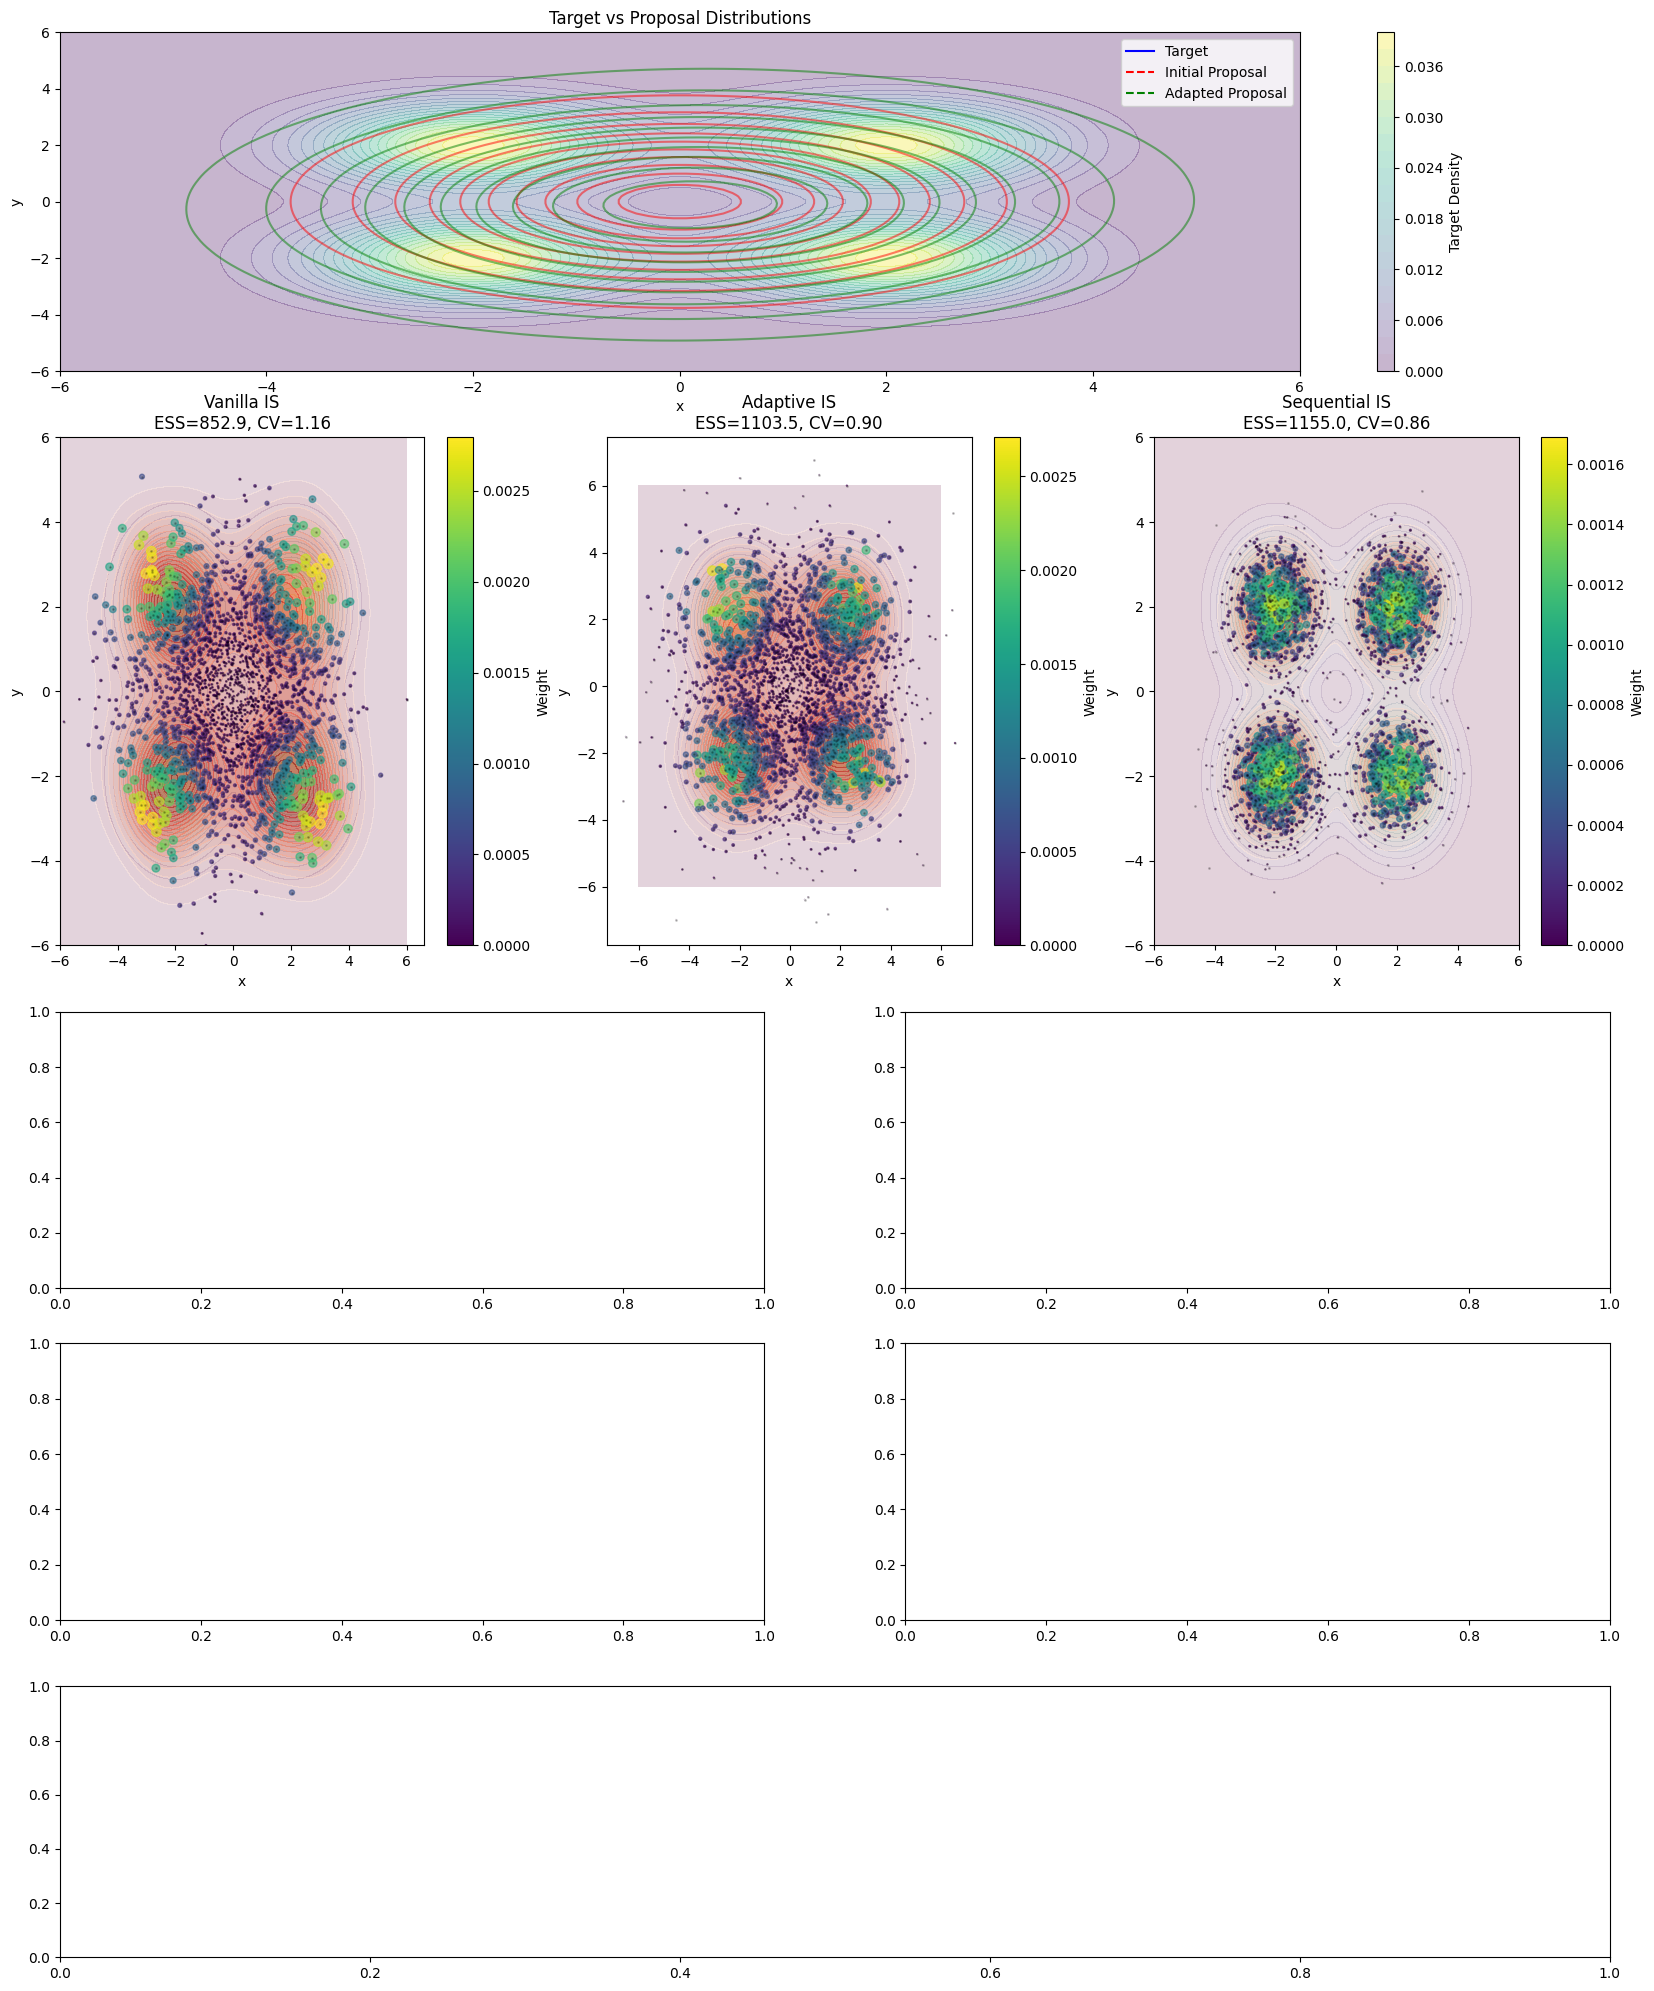

In [5]:
sampler_2d = ImportanceSamplers(target_type='mixture')

_ = sampler_2d.run_vanilla_is(n_samples=n_iter)
_ = sampler_2d.run_adaptive_is(n_samples=n_iter, n_iterations=10)
_ = sampler_2d.run_sequential_is(n_particles=n_iter, n_steps=20)

# Print final diagnostics
print("\nFinal Diagnostics:")
print("Vanilla IS:", sampler_2d.compute_diagnostics(sampler_2d.weights_vanilla))
print("Adaptive IS:", sampler_2d.compute_diagnostics(sampler_2d.weights_adaptive))
print("Sequential IS:", sampler_2d.compute_diagnostics(sampler_2d.weights_sequential))

sampler_2d.plot_comparison(time_step=n_iter)

In [ ]:
# Create interactive visualization with more steps
widgets.interact(sampler_2d.plot_comparison,
                time_step=widgets.IntSlider(min=0,
                                          max=n_iter,  # increased max
                                          step=int(n_iter/100),    # increased step size
                                          value=0,
                                          description='Time Step',
                                          continuous_update=False))

### 3D data

In [ ]:
# Example usage for 3D case
sampler_3d = ImportanceSamplers(target_type='3d')

# Run all sampling methods
_ = sampler_3d.run_vanilla_is(n_samples=n_iter)
_ = sampler_3d.run_adaptive_is(n_samples=n_iter, n_iterations=10)
_ = sampler_3d.run_sequential_is(n_particles=n_iter, n_steps=20)

# Print final diagnostics
print("\nFinal Diagnostics:")
print("Vanilla IS:", sampler_3d.compute_diagnostics(sampler_3d.weights_vanilla))
print("Adaptive IS:", sampler_3d.compute_diagnostics(sampler_3d.weights_adaptive))
print("Sequential IS:", sampler_3d.compute_diagnostics(sampler_3d.weights_sequential))

sampler_3d.plot_comparison(time_step=n_iter)

In [ ]:
# Create interactive visualization with more steps
widgets.interact(sampler_3d.plot_comparison,
                time_step=widgets.IntSlider(min=0,
                                          max=n_iter,  # increased max
                                          step=int(n_iter/100),    # increased step size
                                          value=0,
                                          description='Time Step',
                                          continuous_update=False))